In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree


In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = y_train.flatten()
y_test = y_test.flatten()

# Appiattisci immagini
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# Unisci tutto in un unico dataset
X = np.concatenate((x_train_flat, x_test_flat), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# Concatenazione dati e target
dati_completi = np.c_[X, y]

# Split settings
train_fraction = 0.8
val_fraction = 0.25

shape_total = dati_completi.shape[0]
shape_train = int(shape_total * train_fraction)
shape_val = int(shape_train * val_fraction)

# Split dataset
train_set = dati_completi[:shape_train]
test_set = dati_completi[shape_train:]

val_set = train_set[:shape_val]
train_effettivo_set = train_set[shape_val:]

x_train_eff, y_train_eff = train_effettivo_set[:, :-1], train_effettivo_set[:, -1]
x_val, y_val = val_set[:, :-1], val_set[:, -1]
x_test, y_test = test_set[:, :-1], test_set[:, -1]

# Training set completo (opzionale)
#X_train_full = np.concatenate((X_train_eff, X_val))
#y_train_full = np.concatenate((y_train_eff, y_val))

#standardizzazione
scaler = StandardScaler()
x_train_std = scaler.fit_transform(x_train_eff)
x_test_std = scaler.transform(x_test)

from sklearn.utils import resample

#SOTTOCAMPIONAMENTO (opzionale)
# Esempio: prendi 10000 esempi invece di 50000
x_train_small, y_train_small = resample(x_train_std, y_train_eff, n_samples=10000, random_state=42)


In [4]:

from sklearn.decomposition import PCA


pca = PCA(n_components=100) # riduce a 100 componenti

# Adatta il modello ai dati di training
x_train_pca = pca.fit_transform(x_train_small)

# Trasforma i dati di test usando la stessa PCA
x_test_pca = pca.transform(x_test_std)

explained = np.sum(pca.explained_variance_ratio_)
print(f"PCA con 100 componenti spiega il {explained:.2%} della varianza totale")





PCA con 100 componenti spiega il 89.91% della varianza totale


Logistic Regression:
 0.37366666666666665
k-NN:
 0.3104166666666667
[1 0 2 ... 5 1 7]
[5 0 3 ... 3 5 7]
SVM:
 0.37625
Decision Tree:
 0.2245


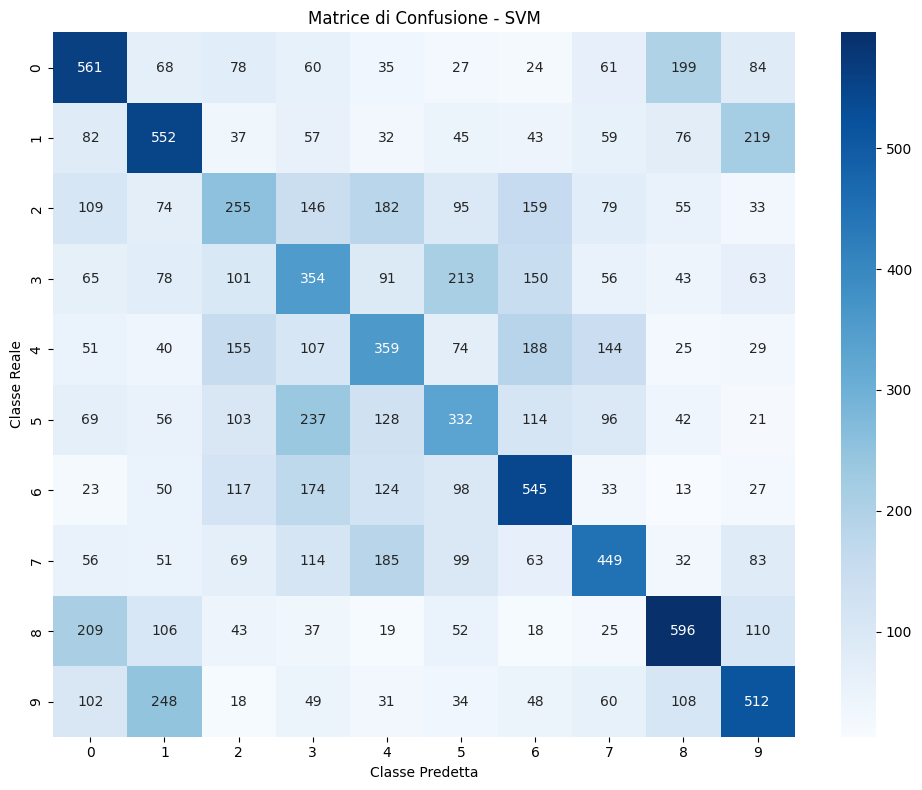

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

#Regressione logistica
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(x_train_pca, y_train_small)
y_pred_lr = log_reg.predict(x_test_pca)
print("Logistic Regression:\n", accuracy_score(y_test, y_pred_lr))

#KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train_pca, y_train_small)
y_pred_knn = knn.predict(x_test_pca)
print("k-NN:\n", accuracy_score(y_test, y_pred_knn))

#SVM
svm = SVC(kernel='linear')
svm.fit(x_train_pca, y_train_small)
y_pred_svm = svm.predict(x_test_pca)
print(y_test)
print(y_pred_svm)
print("SVM:\n", accuracy_score(y_test, y_pred_svm))

# Decision Tree
dtree = DecisionTreeClassifier(max_depth=20)
dtree.fit(x_train_pca, y_train_small)
y_pred_dt = dtree.predict(x_test_pca)
print("Decision Tree:\n", accuracy_score(y_test, y_pred_dt))

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Supponendo che y_test e y_pred_svm siano già definiti
cm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice di Confusione - SVM')
plt.xlabel('Classe Predetta')
plt.ylabel('Classe Reale')
plt.tight_layout()
plt.savefig('matrice_confusione_svm.png')
plt.show()




In [5]:
#utilizzo di GridSearch per effettuare la model selection

from sklearn.model_selection import GridSearchCV

#logistic regression
param_lr = {
    'C': [0.01, 0.1, 1, 10]

}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_lr, cv=3, scoring='accuracy' )
grid_lr.fit(x_train_pca, y_train_small)
best_lr = grid_lr.best_estimator_
best_lr_acc=grid_lr.best_score_
print("Logistic Regression Best Params:", best_lr)
print("best accuracy_score:", best_lr_acc)
print("classification report:", classification_report(y_test, grid_lr.predict(x_test_pca)))




# k-NN
param_knn = {
    'n_neighbors': [3, 5, 7]
}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_knn, cv=3, scoring='accuracy')
grid_knn.fit(x_train_pca, y_train_small)
best_knn = grid_knn.best_estimator_
best_knn_acc=grid_knn.best_score_
print("k-NN Best Params:", best_knn)
print("best accuracy_score:",best_knn_acc)
print("classification report:", classification_report(y_test, grid_knn.predict(x_test_pca)))

#SVM
param_svm = {
    'C': [0.1, 1],
    'kernel': ['linear', 'rbf']
}
grid_svm = GridSearchCV(SVC(), param_svm, cv=3, scoring='accuracy')
grid_svm.fit(x_train_pca, y_train_small)
best_svm = grid_svm.best_estimator_
best_svm_acc=grid_svm.best_score_
print("SVM Best Params:", best_svm)
print("best accuracy_score:", best_svm_acc)
print("classification report:", classification_report(y_test, grid_svm.predict(x_test_pca)))


#Decision Tree
param_dt = {
    'max_depth': [10, 15, 20, 25]
}
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_dt, cv=3, scoring='accuracy', verbose=1)
grid_dt.fit(x_train_pca, y_train_small)
best_dt = grid_dt.best_estimator_
best_dt_acc=grid_dt.best_score_
print("Decision Tree Best Params:", grid_dt.best_params_)
print("best accuracy_score:", best_dt_acc)
print("classification report:", classification_report(y_test, grid_dt.predict(x_test_pca)))



ValueError: Found input variables with inconsistent numbers of samples: [10000, 50000]

In [ ]:
# Matrici di confusione (una per ogni classificatore)

from sklearn.metrics import confusion_matrix
y_pred_lr = best_lr.predict(x_test_pca)
y_pred_dt = best_dt.predict(x_test_pca)
y_pred_knn = best_knn.predict(x_test_pca)
y_pred_svm = best_svm.predict(x_test_pca)

confusion_matrix_lr = confusion_matrix(y_test, y_pred_lr)
print("Logistic Regression Confusion Matrix:")
print(confusion_matrix_lr)

confusion_matrix_knn = confusion_matrix(y_test, y_pred_knn)
print("k-NN Confusion Matrix:")
print(confusion_matrix_knn)

confusion_matrix_svm = confusion_matrix(y_test, y_pred_svm)
print("SVM Confusion Matrix:")
print(confusion_matrix_svm)


confusion_matrix_dt = confusion_matrix(y_test, y_pred_dt)
print("Decision Tree Confusion Matrix:")
print(confusion_matrix_dt)




In [ ]:




# Visualizzazione delle matrici di confusione

def plot_confusion_matrix(cm):
    import seaborn as sns
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[f'Class {i}' for i in range(10)], yticklabels=[f'Class {i}' for i in range(10)])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


plot_confusion_matrix(confusion_matrix_lr)
plot_confusion_matrix(confusion_matrix_knn)
plot_confusion_matrix(confusion_matrix_svm)
plot_confusion_matrix(confusion_matrix_dt)

In [ ]:
from sklearn.metrics import accuracy_score

#scelta del modello dalle migliori prestazioni

best_lr_acc = accuracy_score(y_test, grid_lr.predict(x_test_pca))
best_knn_acc = accuracy_score(y_test, grid_knn.predict(x_test_pca))
best_svm_acc = accuracy_score(y_test, grid_svm.predict(x_test_pca))
best_dt_acc = accuracy_score(y_test, grid_dt.predict(x_test_pca))


accuracies = [best_lr_acc, best_knn_acc, best_svm_acc, best_dt_acc]
model_names = ["Logistic Regression", "k-NN", "SVM", "Decision Tree"]
best_index = accuracies.index(max(accuracies))
best_model_name = model_names[best_index]
print(f" Modello migliore: {best_model_name} (accuracy: {accuracies[best_index]:.4f})")



#visualizzazione della relativa confusion matrix
best_model = [best_lr, best_knn, best_svm, best_dt][best_index]
y_pred = best_model.predict(x_test_pca)
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)
